In [3]:
import sys
sys.path.append("../../Chapter_3/")

import pickle

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fastai
from fastai.basics import Learner, DataLoaders
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.torch_core import trainable_params

# from Utils.model_datasets import RPIDataset
from Utils.train import set_seed, MainModelDenseInputSizeCalculator, main_model_splitter
from Utils.model_utils import LossLogger
from Utils.model_datasets import EncodedRPIDataset
from Utils.model_blocks import *
from Utils.train import BlockInputShapeReformatter, MainModelDenseInputSizeCalculator

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import seaborn as sbn
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, matthews_corrcoef


In [4]:
NNI_DIR = "/data/Chapter_3/nni"

models = ('Dense','StackedRes','DenseSAE','Attention','Reccurent')

model_eval = {model : pd.read_csv(f"{NNI_DIR}/experiment_results/Main_{model}.csv", index_col = 0).dropna().sort_values('final_metric')
              for model in models}

In [5]:
def determine_block_name_from_params(params):
    """
    Searches for a parameter exclusive to a different block type
    within the given parameters, and returns the corresponding
    block name. 
    """
    
    param_names = params.keys()
    if 'pooling_type' in param_names:
        return 'ConvPool'
    elif 'reccurent_type' in param_names:
        return 'Reccurent'
    elif 'layer_count' in param_names:
        return 'Attention'
    elif 'hidden_sizes' in param_names:
        return 'StackedRes'
    elif 'hidden_layer_sizes' in param_names:
        return 'Dense'
    elif 'sae_type' in param_names:
        return 'SAE'
    
class BlockInializer:
    """
    Used to initialize MainModel blocks from the parameters and 
    """
    
    def __init__(self, seed):
        self.seed = seed
    
    def _reformat_block_act(self, block_params):
        preprocessed_block_str = re.sub(r"'act': 'nn.(.+?)\(\)'", r"'act': nn.\1()", block_params)
        preprocessed_block_str = re.sub(r"'act_cls': 'nn.(.+?)\'", r"'act_cls': nn.\1", preprocessed_block_str)
        return preprocessed_block_str
    
    def _reformat_list_str(self, block_params):
        preprocessed_block_str = re.sub(r"'\[(.*)\]'", r"[\1]", block_params)
        return preprocessed_block_str
    
    def generate_block_str(self, block_name, input_size, block_params):
        return f"{block_name}Block({input_size}, **{block_params})"
    
    def _reformat_sae_block(self, input_size, preprocessed_block_str):
        return preprocessed_block_str.replace(f"{input_size}, ","")
    
    def initialize_block(self, block_name, input_size, block_params):
        block_str = self.generate_block_str(block_name, input_size, block_params)
        preprocessed_block_str = self._reformat_block_act(block_str)
        preprocessed_block_str = self._reformat_list_str(preprocessed_block_str)
        
        if block_name == 'SAE':
            preprocessed_block_str = self._reformat_sae_block(input_size, preprocessed_block_str)
        
        set_seed(self.seed)
        print(preprocessed_block_str)
        return eval(preprocessed_block_str)

def swap_seq_input_order(data : list) -> None:
    seq1, seq2 = data[0], data[1]
    data[0] = seq2
    data[1] = seq1

def initiate_lr_option(lr_option, lr_min, lr_steep):
    "having min first is intentional. It results in better performance"
    options = {'slice' : slice(lr_min, lr_steep), 'min' : lr_min}
    return options[lr_option]

In [6]:
model_eval['StackedRes'].iloc[0,:].to_dict()

{'batchsize': 32,
 'dense_hidden_layers': '[3000, 2000, 1000, 10]',
 'p': 0.2,
 'act': 'None',
 'bn': False,
 'lin_first': False,
 'lr_max_arg': 'slice',
 'rna_hidden_sizes': '[70, 40, 10]',
 'rna_act_cls': 'nn.Sigmoid',
 'rna_bn_1st': False,
 'prot_hidden_sizes': '[55, 10]',
 'prot_act_cls': 'nn.ReLU',
 'prot_bn_1st': True,
 'final_metric': 0.0482180081307888}

In [5]:
SEED = 255

PARAMS = model_eval['StackedRes'].iloc[0,:].to_dict()
PARAMS

_ = PARAMS.pop("final_metric")
LR_OPTION = PARAMS.pop("lr_max_arg")
BATCHSIZE = PARAMS.pop("batchsize")
MAIN_ACT = eval(PARAMS.pop("act"))

main_model_params = {key : value for key,value in PARAMS.items() if 'rna' not in key and 'prot' not in key}
rna_block_params = {key.replace("rna_","") : value for key,value in PARAMS.items() if 'rna' in key}
prot_block_params = {key.replace("prot_","") : value for key,value in PARAMS.items() if 'prot' in key}

rna_block_name = determine_block_name_from_params(rna_block_params)
prot_block_name = determine_block_name_from_params(prot_block_params)

# TEMPORARY: ASSUMES THAT PROT AND RNA BLOCKS ARE IDENTICAL
block_name = prot_block_name
block_name

'StackedRes'

In [7]:
#####################################################
# Load params
######################################################

with open("../Data/TrainingData/FullEmbeddedTrainingData.pickle",'rb') as handle:
    data = pickle.load(handle)
    print(f"Total training data: {len(data[0])}")
    print(f"Total positive interactions: {sum(data[-1])}")
    print(f"Total negative interactions: {len(data[-1]) - sum(data[-1])}")

Total training data: 24294
Total positive interactions: 12147.0
Total negative interactions: 12147.0


In [11]:
from tqdm.notebook import tqdm

  0%|          | 0/5 [00:00<?, ?it/s]

DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})


epoch,train_loss,valid_loss,time
0,0.406051,0.222645,00:03
1,0.312130,0.164714,00:03
2,0.287990,0.140308,00:03
3,0.276178,0.128403,00:03
4,0.255821,0.116298,00:03
5,0.252889,0.111330,00:03
6,0.243031,0.102817,00:03
7,0.232752,0.098659,00:03
8,0.234854,0.093567,00:03
9,0.237825,0.090115,00:03


No improvement since epoch 58: early stopping
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})


epoch,train_loss,valid_loss,time
0,0.409303,0.243432,00:03
1,0.309674,0.179973,00:03
2,0.281425,0.154879,00:03
3,0.265318,0.143242,00:03
4,0.247379,0.129397,00:03
5,0.241300,0.123463,00:03
6,0.235132,0.113876,00:03
7,0.227006,0.110389,00:03
8,0.236065,0.107135,00:03
9,0.226747,0.099871,00:03


No improvement since epoch 48: early stopping
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})


epoch,train_loss,valid_loss,time
0,0.447924,0.288354,00:03
1,0.319493,0.202795,00:03
2,0.291767,0.174863,00:03
3,0.269474,0.157224,00:03
4,0.252847,0.141362,00:03
5,0.250511,0.130995,00:03
6,0.243915,0.123961,00:03
7,0.236388,0.113881,00:03
8,0.231694,0.112867,00:03
9,0.230255,0.105937,00:03


No improvement since epoch 37: early stopping
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})


epoch,train_loss,valid_loss,time
0,0.447750,0.270469,00:03
1,0.314872,0.181194,00:03
2,0.287777,0.149473,00:03
3,0.276555,0.135006,00:03
4,0.249321,0.116500,00:03
5,0.250488,0.107299,00:03
6,0.247413,0.099983,00:03
7,0.241191,0.095534,00:03
8,0.236598,0.088214,00:03
9,0.233648,0.083995,00:03


No improvement since epoch 33: early stopping
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})
DenseBlock(1024, **{'hidden_layer_sizes': [840, 680, 520, 360, 200], 'p': 0.8, 'act': nn.Sigmoid(), 'bn': False, 'lin_first': False})
DenseBlock(1024, **{'hidden_layer_sizes': [600, 200], 'p': 0.2, 'act': nn.ReLU(), 'bn': False, 'lin_first': True})


epoch,train_loss,valid_loss,time
0,0.418819,0.256459,00:03
1,0.317042,0.189797,00:03
2,0.288619,0.163689,00:03
3,0.271018,0.148757,00:03
4,0.253303,0.131935,00:03
5,0.252742,0.124247,00:03
6,0.245838,0.117276,00:03
7,0.245682,0.112643,00:03
8,0.237380,0.104234,00:03
9,0.231595,0.102895,00:03


No improvement since epoch 48: early stopping
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})


epoch,train_loss,valid_loss,time
0,0.288335,0.228136,00:10
1,0.238510,0.174065,00:10
2,0.200082,0.136850,00:10
3,0.172269,0.127613,00:10
4,0.150293,0.129133,00:10
5,0.138957,0.122051,00:10
6,0.122444,0.107041,00:10
7,0.113492,0.106169,00:10
8,0.110688,0.103089,00:10
9,0.109668,0.101200,00:10


No improvement since epoch 42: early stopping
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})


epoch,train_loss,valid_loss,time
0,0.288752,0.256233,00:10
1,0.223898,0.193489,00:10
2,0.198566,0.164352,00:10
3,0.161777,0.158365,00:10
4,0.147728,0.142887,00:09
5,0.139026,0.143048,00:08
6,0.133233,0.117530,00:08
7,0.122960,0.117590,00:08
8,0.137823,0.116460,00:09
9,0.116009,0.114026,00:09


No improvement since epoch 24: early stopping
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})


epoch,train_loss,valid_loss,time
0,0.318260,0.318073,00:10
1,0.248517,0.231344,00:10
2,0.206271,0.195101,00:10
3,0.189572,0.188517,00:10
4,0.158900,0.179161,00:10
5,0.169747,0.169656,00:10
6,0.160723,0.142989,00:10
7,0.153712,0.139089,00:09
8,0.122964,0.140915,00:09
9,0.118091,0.136729,00:09


No improvement since epoch 24: early stopping
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})


epoch,train_loss,valid_loss,time
0,0.374126,0.335641,00:10
1,0.290812,0.250828,00:10
2,0.264581,0.199947,00:10
3,0.228100,0.185948,00:10
4,0.213976,0.159424,00:10
5,0.207459,0.159123,00:10
6,0.190196,0.134225,00:10
7,0.169641,0.128002,00:10
8,0.162134,0.118540,00:10
9,0.169948,0.112905,00:10


No improvement since epoch 44: early stopping
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})


epoch,train_loss,valid_loss,time
0,0.292560,0.267943,00:10
1,0.239080,0.207295,00:10
2,0.205257,0.167165,00:10
3,0.174641,0.152607,00:10
4,0.162289,0.138544,00:10
5,0.168355,0.150460,00:10
6,0.148335,0.114709,00:10
7,0.142111,0.111405,00:10
8,0.123491,0.115366,00:10
9,0.125714,0.103980,00:10


No improvement since epoch 46: early stopping
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})


epoch,train_loss,valid_loss,time
0,0.693112,0.693086,00:02
1,0.655587,0.602333,00:02
2,0.537114,0.499385,00:02
3,0.508215,0.477505,00:02
4,0.488435,0.465755,00:02
5,0.485050,0.457301,00:02
6,0.482641,0.451205,00:02
7,0.475256,0.446708,00:02
8,0.470949,0.443822,00:02
9,0.471461,0.441848,00:02


No improvement since epoch 94: early stopping
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})


epoch,train_loss,valid_loss,time
0,0.693103,0.693072,00:02
1,0.631615,0.564241,00:02
2,0.516449,0.498000,00:02
3,0.497104,0.482480,00:02
4,0.478943,0.474994,00:02
5,0.477880,0.470020,00:02
6,0.473321,0.465794,00:02
7,0.470231,0.462119,00:02
8,0.470216,0.457795,00:02
9,0.465285,0.455282,00:02


No improvement since epoch 74: early stopping
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})


epoch,train_loss,valid_loss,time
0,0.597723,0.507039,00:02
1,0.492582,0.479586,00:02
2,0.475345,0.468781,00:02
3,0.466629,0.467041,00:02
4,0.452770,0.457176,00:02
5,0.450972,0.449427,00:02
6,0.445112,0.453900,00:02
7,0.439974,0.441794,00:02
8,0.430573,0.437932,00:02
9,0.421257,0.430411,00:02


No improvement since epoch 59: early stopping
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})


epoch,train_loss,valid_loss,time
0,0.587273,0.493277,00:02
1,0.491992,0.463152,00:02
2,0.471957,0.452394,00:02
3,0.470493,0.446791,00:02
4,0.451068,0.440245,00:02
5,0.451722,0.430708,00:02
6,0.449109,0.428618,00:02
7,0.443093,0.427056,00:02
8,0.436171,0.425076,00:02
9,0.429577,0.415628,00:02


No improvement since epoch 74: early stopping
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt'})
SAEBlock(**{'sae_type': 'Dense', 'sae_model_path': '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt'})


epoch,train_loss,valid_loss,time
0,0.595141,0.503792,00:02
1,0.500857,0.479116,00:02
2,0.476829,0.465272,00:02
3,0.468313,0.456534,00:02
4,0.450989,0.453781,00:02
5,0.452083,0.446729,00:02
6,0.446496,0.440042,00:02
7,0.440470,0.433584,00:02
8,0.430805,0.429339,00:02
9,0.426979,0.426638,00:02


No improvement since epoch 50: early stopping
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})


epoch,train_loss,valid_loss,time
0,0.313070,0.244215,00:37
1,0.242603,0.188821,00:30
2,0.216145,0.165229,00:32
3,0.205099,0.155765,00:31
4,0.181534,0.149744,00:30
5,0.179737,0.138496,00:31
6,0.167059,0.132900,00:30
7,0.153367,0.126550,00:30
8,0.160104,0.124236,00:30
9,0.158187,0.118287,00:30


No improvement since epoch 33: early stopping
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})


epoch,train_loss,valid_loss,time
0,0.255938,0.235745,00:38
1,0.211102,0.198602,00:26
2,0.188265,0.179093,00:31
3,0.172812,0.169751,00:30
4,0.155574,0.167045,00:30
5,0.160113,0.154855,00:30
6,0.145446,0.148207,00:30
7,0.142339,0.155472,00:31
8,0.145855,0.144865,00:30
9,0.149092,0.140773,00:31


No improvement since epoch 35: early stopping
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})


epoch,train_loss,valid_loss,time
0,0.320053,0.294385,00:40
1,0.240293,0.235289,00:27
2,0.219667,0.213289,00:29
3,0.193856,0.205017,00:31
4,0.181628,0.191321,00:31
5,0.185137,0.177533,00:32
6,0.169827,0.170682,00:32
7,0.168786,0.163973,00:32
8,0.156136,0.159839,00:31
9,0.155345,0.155737,00:31


No improvement since epoch 37: early stopping
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})


epoch,train_loss,valid_loss,time
0,0.319853,0.264279,00:41
1,0.244580,0.204719,00:28
2,0.221282,0.185323,00:31
3,0.208146,0.165694,00:31
4,0.186466,0.153196,00:31
5,0.180642,0.146195,00:31
6,0.180904,0.138208,00:31
7,0.169070,0.134202,00:31
8,0.166780,0.128487,00:31
9,0.170465,0.122771,00:30


No improvement since epoch 33: early stopping
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})
AttentionBlock(1024, **{'layer_count': 32})
AttentionBlock(1024, **{'layer_count': 8})


epoch,train_loss,valid_loss,time
0,0.268310,0.241909,00:42
1,0.227702,0.204178,00:32
2,0.199268,0.190493,00:32
3,0.181408,0.174537,00:34
4,0.161746,0.162546,00:33
5,0.168975,0.156567,00:32
6,0.157533,0.148621,00:30
7,0.155293,0.139982,00:30
8,0.145127,0.140040,00:30
9,0.140383,0.137346,00:30


No improvement since epoch 46: early stopping
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


/home/bobby/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7000000000000001 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


/home/bobby/anaconda3/lib/python3.8/site-packages/fastai/callback/schedule.py:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


epoch,train_loss,valid_loss,time
0,0.291685,0.213042,00:08
1,0.225838,0.170587,00:08
2,0.212556,0.146657,00:08
3,0.190649,0.139308,00:08
4,0.164973,0.128893,00:08
5,0.151940,0.118569,00:08
6,0.139798,0.118466,00:08
7,0.141963,0.109096,00:08
8,0.132526,0.104969,00:08
9,0.132946,0.096877,00:08


No improvement since epoch 29: early stopping
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


/home/bobby/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7000000000000001 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


epoch,train_loss,valid_loss,time
0,0.352705,0.291999,00:08
1,0.263170,0.230361,00:08
2,0.225657,0.199368,00:08
3,0.206409,0.186998,00:08
4,0.182932,0.171610,00:08
5,0.179353,0.165347,00:08
6,0.166348,0.157048,00:08
7,0.162955,0.152516,00:08
8,0.167852,0.144899,00:08
9,0.163963,0.140931,00:08


No improvement since epoch 35: early stopping
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


/home/bobby/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7000000000000001 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


epoch,train_loss,valid_loss,time
0,0.348715,0.293049,00:08
1,0.251428,0.230690,00:08
2,0.225728,0.201927,00:08
3,0.203486,0.199510,00:08
4,0.186316,0.184586,00:08
5,0.186518,0.163486,00:08
6,0.178319,0.157128,00:08
7,0.161327,0.151673,00:08
8,0.144006,0.144981,00:08
9,0.144833,0.134488,00:08


No improvement since epoch 21: early stopping
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


/home/bobby/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7000000000000001 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


epoch,train_loss,valid_loss,time
0,0.296836,0.242093,00:08
1,0.237828,0.186836,00:08
2,0.212195,0.158790,00:08
3,0.192988,0.136545,00:08
4,0.169311,0.122960,00:08
5,0.160687,0.118723,00:08
6,0.155101,0.113242,00:08
7,0.143536,0.102120,00:08
8,0.142632,0.095718,00:08
9,0.138403,0.103397,00:08


No improvement since epoch 36: early stopping
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


/home/bobby/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7000000000000001 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.4, 'num_layers': 2, 'hidden_size': 32})
ReccurentBlock(1024, **{'reccurent_type': 'GRU', 'bidirectional': True, 'dropout': 0.7000000000000001, 'num_layers': 1, 'hidden_size': 8})


epoch,train_loss,valid_loss,time
0,0.289563,0.245677,00:08
1,0.238526,0.202271,00:08
2,0.206238,0.183816,00:08
3,0.184973,0.168940,00:08
4,0.164252,0.159646,00:08
5,0.163229,0.148352,00:08
6,0.151879,0.144554,00:08
7,0.146399,0.132782,00:08
8,0.139104,0.130388,00:08
9,0.129364,0.125341,00:08


No improvement since epoch 46: early stopping


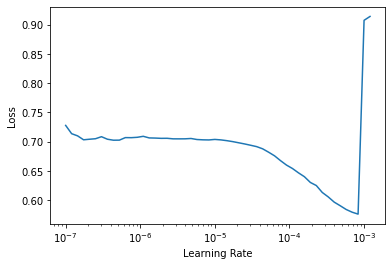

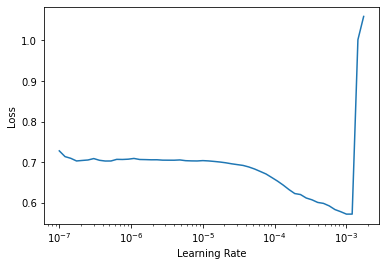

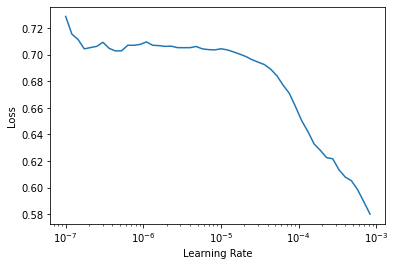

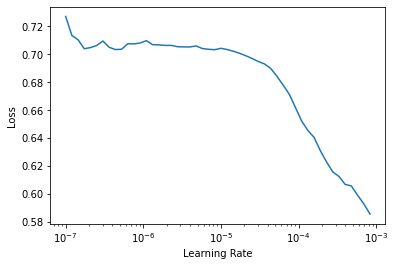

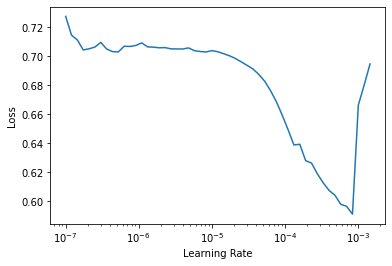

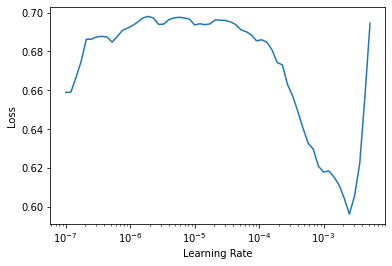

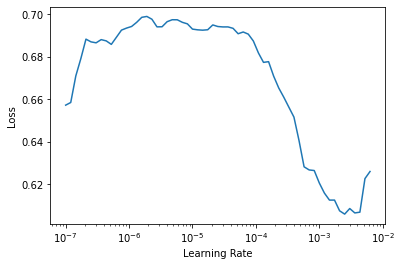

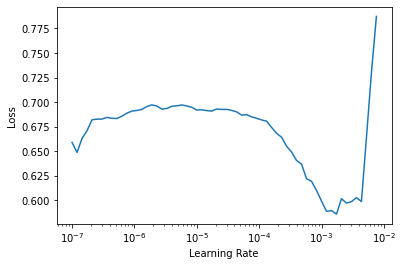

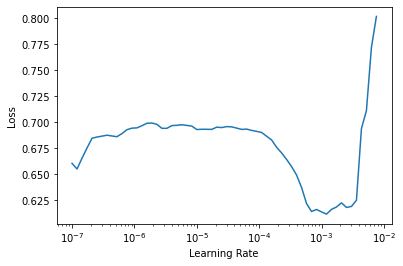

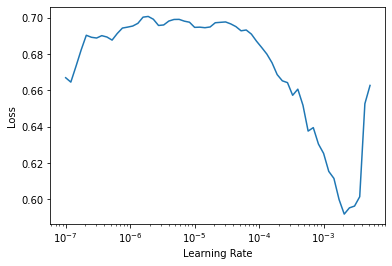

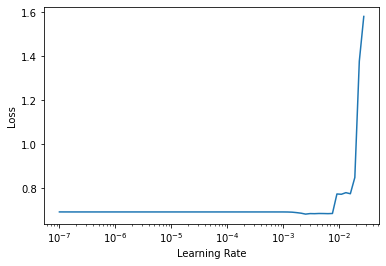

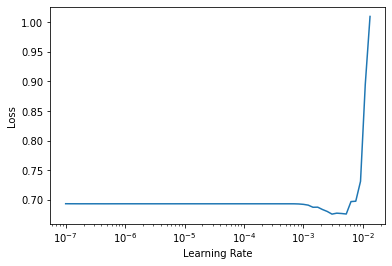

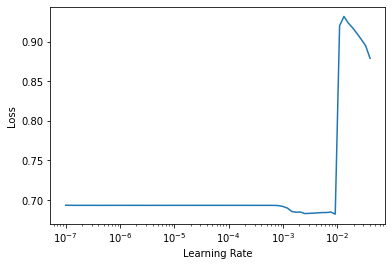

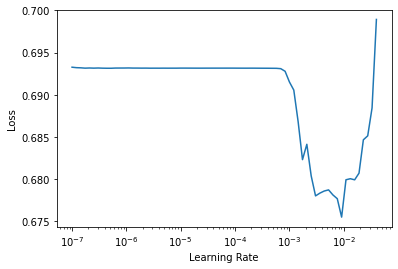

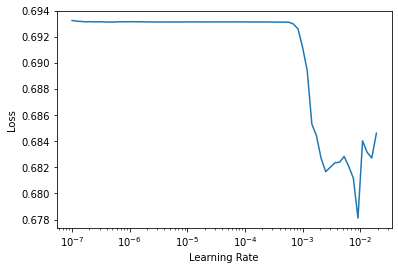

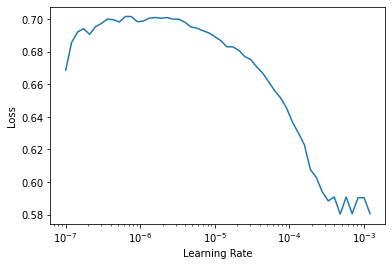

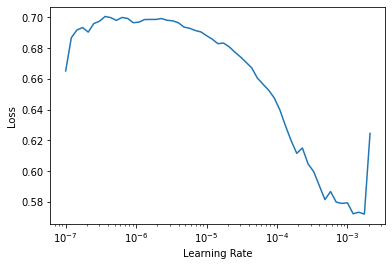

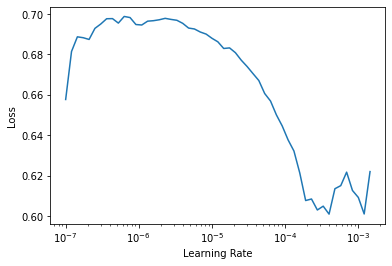

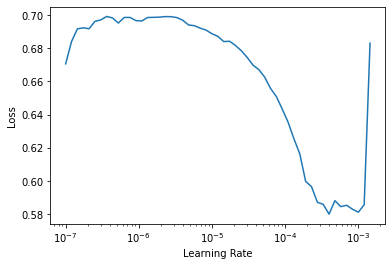

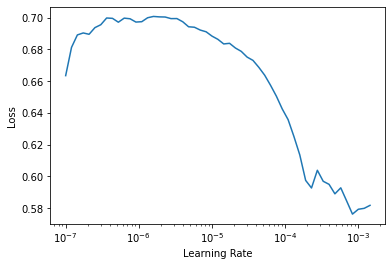

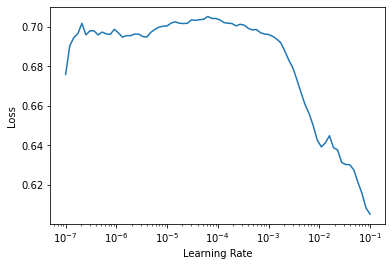

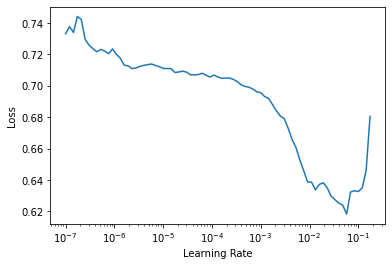

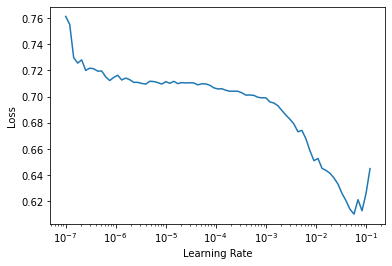

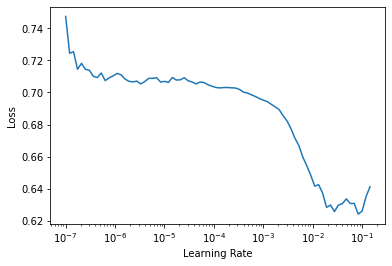

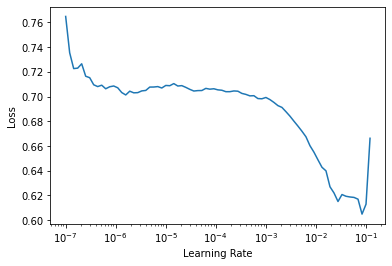

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, matthews_corrcoef

FOLD_EVAL = True

shape_reformatter = BlockInputShapeReformatter()
# BLOCKNAMES = "Dense"
PATIENCE = 10
SEED = 255

model_fold_eval = {blockname : {'acc' : list(), 'f1' : list(), 'auroc' : list(), 'mcc' : list()} for blockname in models}

if FOLD_EVAL:
    
    for blockname in tqdm(models):
        
        PARAMS = model_eval[blockname].iloc[0,:].to_dict()
        
        _ = PARAMS.pop("final_metric")
        LR_OPTION = PARAMS.pop("lr_max_arg")
        BATCHSIZE = PARAMS.pop("batchsize")
        MAIN_ACT = eval(PARAMS.pop("act"))

        main_model_params = {key : value for key,value in PARAMS.items() if 'rna' not in key and 'prot' not in key}
        rna_block_params = {key.replace("rna_","") : value for key,value in PARAMS.items() if 'rna' in key}
        prot_block_params = {key.replace("prot_","") : value for key,value in PARAMS.items() if 'prot' in key}

        rna_block_name = determine_block_name_from_params(rna_block_params)
        prot_block_name = determine_block_name_from_params(prot_block_params)
        
        skf = StratifiedKFold(n_splits = 5, random_state = 255, shuffle = True)
        skf.get_n_splits(data[0], data[-1])

        for train_index, test_index in skf.split(data[0], data[-1]):

            #####################################################
            # Generate train, test, val data
            #####################################################

            train_data, test_data = zip(*[(X[train_index], X[test_index]) for X in data])

            test_idx, val_idx = train_test_split(range(len(test_data[0])), random_state = 255, test_size = 0.5, 
                                                 stratify = test_data[-1])

            test_data, val_data = zip(*[(X[test_idx], X[val_idx]) for X in test_data])

#             print(f"""Train data: {len(train_data[0])} | + samples: {sum(train_data[-1])} | - samples: {len(train_data[-1]) - sum(train_data[-1])}    
#         Test data: {len(test_data[0])} | + samples: {sum(test_data[-1])} | - samples: {len(test_data[-1]) - sum(test_data[-1])}
#         Val data: {len(val_data[0])} | + samples: {sum(val_data[-1])} | - samples: {len(val_data[-1]) - sum(val_data[-1])}
#         ---""")

            #####################################################
            # Preprocess train, test, val data
            #####################################################

            refine_train_data = [shape_reformatter.reformat_input(blockname, train_data[i].float()) for i in range(2)] + [train_data[-1].float()]
            swap_seq_input_order(refine_train_data)
            refine_train_dataset = EncodedRPIDataset(refine_train_data)

            refine_val_data = [shape_reformatter.reformat_input(blockname, val_data[i].float()) for i in range(2)] + [val_data[-1].float()]
            swap_seq_input_order(refine_val_data)
            refine_val_dataset = EncodedRPIDataset(refine_val_data)

            refine_test_data = [shape_reformatter.reformat_input(blockname, test_data[i].float()) for i in range(2)] + [test_data[-1].float()]
            proteins, rnas, y_true = refine_test_data
            y_true = y_true.reshape(-1,1)

            #####################################################
            # Generate model
            #####################################################

            block_initializer = BlockInializer(SEED)

            # Temporarily initializes blocks to calculate input size
            rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
            prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

            dense_input_calculator = MainModelDenseInputSizeCalculator(refine_train_data[0], refine_train_data[1])
            dense_input_size = dense_input_calculator.calcualte_input_shape(rna_blocks  = [rna_block.cpu()], 
                                                                            prot_blocks = [prot_block.cpu()])

            rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
            prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

            main_model_params = eval(block_initializer._reformat_list_str(str(main_model_params)))

            set_seed(255)
            main_model = MainModel(rna_blocks  = [rna_block],
                                   prot_blocks = [prot_block],
                                   dense_input_size = dense_input_size,
                                   act = MAIN_ACT,
                                   **main_model_params).cuda()

            #####################################################
            # Train model
            #####################################################

            set_seed(255)
            loaders = DataLoaders.from_dsets(refine_train_dataset, refine_val_dataset,
                                             bs = BATCHSIZE,
                                             device = 0)

            learner = Learner(loaders, main_model,
                              splitter = main_model_splitter,
                              cbs = [EarlyStoppingCallback(patience = PATIENCE)],
                              loss_func = nn.BCELoss())

            lr_min, lr_steep = learner.lr_find()

            max_lr_arg = initiate_lr_option(LR_OPTION, lr_min, lr_steep)
            learner.fit_one_cycle(1000, lr_max = max_lr_arg)

            #####################################################
            # Evaluate performance on HIV-1 data
            #####################################################

            learner.model.eval()
            y_pred = learner.model(rnas.cuda(), proteins.cuda()).cpu().detach().round()
            
            
            model_fold_eval[blockname]['acc'].append(round(accuracy_score(y_true, y_pred),3))
            model_fold_eval[blockname]['f1'].append(round(f1_score(y_true, y_pred),3))
            model_fold_eval[blockname]['auroc'].append(round(roc_auc_score(y_true, y_pred),3))
            model_fold_eval[blockname]['mcc'].append(round(matthews_corrcoef(y_true, y_pred),3))
            
#             print(f"ACCURACY: {round(accuracy_score(y_true, y_pred),3)}")
#             print(f"F1 SCORE: {round(f1_score(y_true, y_pred),3)}")
#             print(f"ROC AUC: {round(roc_auc_score(y_true, y_pred),3)}")
#             print(f"MCC: {round(matthews_corrcoef(y_true, y_pred),3)}")
#             print("---")

In [17]:
for model in model_fold_eval.keys():
    print(model)
    display(pd.DataFrame(model_fold_eval[model]).describe().round(3))

Dense


,acc,f1,auroc,mcc
count,5.000,5.000,5.000,5.000
mean,0.984,0.985,0.984,0.969
std,0.003,0.003,0.003,0.007
min,0.980,0.980,0.980,0.960
25%,0.982,0.983,0.982,0.965
50%,0.985,0.985,0.985,0.970
75%,0.987,0.987,0.987,0.974
max,0.988,0.988,0.988,0.976


StackedRes


,acc,f1,auroc,mcc
count,5.000,5.000,5.000,5.000
mean,0.982,0.982,0.982,0.964
std,0.004,0.004,0.004,0.007
min,0.978,0.978,0.978,0.956
25%,0.980,0.981,0.980,0.961
50%,0.981,0.981,0.981,0.962
75%,0.986,0.986,0.986,0.971
max,0.986,0.986,0.986,0.971


DenseSAE


,acc,f1,auroc,mcc
count,5.000,5.000,5.000,5.000
mean,0.976,0.976,0.976,0.952
std,0.003,0.003,0.003,0.006
min,0.973,0.973,0.973,0.946
25%,0.973,0.974,0.973,0.947
50%,0.974,0.975,0.974,0.950
75%,0.979,0.979,0.979,0.958
max,0.979,0.979,0.979,0.958


Attention


,acc,f1,auroc,mcc
count,5.000,5.000,5.000,5.000
mean,0.968,0.969,0.968,0.937
std,0.004,0.004,0.004,0.008
min,0.965,0.966,0.965,0.931
25%,0.966,0.966,0.966,0.932
50%,0.966,0.967,0.966,0.934
75%,0.969,0.969,0.969,0.938
max,0.975,0.975,0.975,0.950


Reccurent


,acc,f1,auroc,mcc
count,5.000,5.000,5.000,5.000
mean,0.976,0.977,0.976,0.953
std,0.004,0.003,0.004,0.007
min,0.973,0.974,0.973,0.947
25%,0.974,0.974,0.974,0.948
50%,0.974,0.975,0.974,0.949
75%,0.978,0.978,0.978,0.957
max,0.982,0.982,0.982,0.964


In [2]:
# Update with any changes
import pandas as pd

fold_results = pd.DataFrame({"Accuracy" : [0.986, 0.986, 0.98, 0.978, 0.981],
                             "F1 Score" : [0.986, 0.986, 0.981, 0.978, 0.981],
                             "AUROC" : [0.986, 0.986, 0.980, 0.978, 0.981],
                             "MCC" : [0.971, 0.971, 0.961, 0.956, 0.962]})

fold_results.describe().round(3)

,Accuracy,F1 Score,AUROC,MCC
count,5.000,5.000,5.000,5.000
mean,0.982,0.982,0.982,0.964
std,0.004,0.004,0.004,0.007
min,0.978,0.978,0.978,0.956
25%,0.980,0.981,0.980,0.961
50%,0.981,0.981,0.981,0.962
75%,0.986,0.986,0.986,0.971
max,0.986,0.986,0.986,0.971


In [9]:
#####################################################
# Load training data
######################################################

train_idx, val_idx = train_test_split(range(len(data[0])), random_state = SEED, test_size = 0.1, 
                                       stratify = data[-1])

train_data, val_data = zip(*[(X[train_idx], X[val_idx]) for X in data])

train_data = [shape_reformatter.reformat_input(block_name, train_data[i]) for i in range(2)] + [train_data[-1]]
val_data = [shape_reformatter.reformat_input(block_name, val_data[i]) for i in range(2)] + [val_data[-1]]

swap_seq_input_order(train_data)
swap_seq_input_order(val_data)

train_dataset = EncodedRPIDataset(train_data)
val_dataset = EncodedRPIDataset(val_data)

In [10]:
block_initializer = BlockInializer(SEED)

# Temporarily initializes blocks to calculate input size
rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

dense_input_calculator = MainModelDenseInputSizeCalculator(train_data[0], train_data[1])

dense_input_size = dense_input_calculator.calcualte_input_shape(rna_blocks  = [rna_block.cpu()], 
                                                                prot_blocks = [prot_block.cpu()])

set_seed(255)
rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})
StackedResBlock(1024, **{'hidden_sizes': [70, 40, 10], 'act_cls': nn.Sigmoid, 'bn_1st': False})
StackedResBlock(1024, **{'hidden_sizes': [55, 10], 'act_cls': nn.ReLU, 'bn_1st': True})


In [11]:
main_model_params = eval(block_initializer._reformat_list_str(str(main_model_params)))
main_model_params

{'dense_hidden_layers': [3000, 2000, 1000, 10],
 'p': 0.2,
 'bn': False,
 'lin_first': False}

epoch,train_loss,valid_loss,time
0,0.272765,0.213641,00:09
1,0.190086,0.149383,00:09
2,0.170463,0.137746,00:09
3,0.155680,0.113873,00:09
4,0.138959,0.108333,00:09
5,0.134556,0.098267,00:09
6,0.132672,0.086774,00:09
7,0.108989,0.099645,00:09
8,0.082421,0.100140,00:09
9,0.118945,0.094318,00:09


No improvement since epoch 28: early stopping


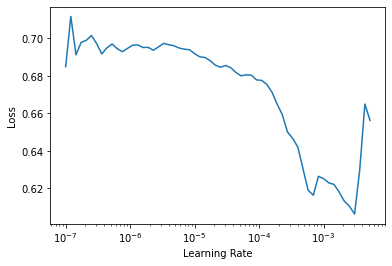

In [12]:
#####################################################
# Generate and train model
#####################################################

PATIENCE = 10

set_seed(255)
main_model = MainModel(rna_blocks  = [rna_block],
                       prot_blocks = [prot_block],
                       dense_input_size = dense_input_size,
                       act = MAIN_ACT,
                       **main_model_params).cuda()

set_seed(255)
loaders = DataLoaders.from_dsets(train_dataset, val_dataset,
                                 bs = BATCHSIZE,
                                 device = 0)

learner = Learner(loaders, main_model,
                  splitter = main_model_splitter,
                  cbs = [EarlyStoppingCallback(patience = PATIENCE)],
                  loss_func = nn.BCELoss())

lr_min, lr_steep = learner.lr_find()

max_lr_arg = initiate_lr_option(LR_OPTION, lr_min, lr_steep)
learner.fit_one_cycle(1000, lr_max = max_lr_arg)

In [13]:
def calculate_avg_train_val_diff_across_final_epochs(learner, epochs) -> float:
    return np.diff(np.array(learner.recorder.values[-epochs:]), axis = 1).mean().round(4)

calculate_avg_train_val_diff_across_final_epochs(learner, 10)

0.0035

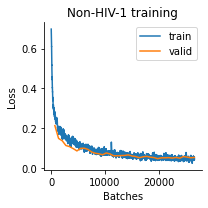

In [14]:
fig, ax = plt.subplots(1,1, figsize = (3,3))

learner.recorder.plot_loss()
sbn.despine()
plt.xlabel("Batches")
plt.ylabel("Loss");
plt.title("Non-HIV-1 training")

plt.tight_layout()
plt.savefig("Non_hiv_RPI_training_curve.png", dpi = 300)

In [17]:
_, val_loss  = zip(*learner.recorder.values)

max_val_loss = max(val_loss)
min_val_loss = min(val_loss)

print(f"""
Max validation loss: {round(max_val_loss,4)}
Min validation loss: {round(min_val_loss,4)}
""")


Max validation loss: 0.2136
Min validation loss: 0.0479



In [18]:
# even though loaded models != learner.model, it results in identical predictions
# learner.model.eval()
# torch.save(learner.model, "../Models/NonRefinedMainModel.torch")

# Predict HIV-1 data w/ unrefined

In [19]:
with open("../Data/TrainingData/FullEmbeddedHIVTrainingData.pickle",'rb') as handle:
    data = pickle.load(handle)

shape_reformatter = BlockInputShapeReformatter()
BLOCKNAME = "StackedRes"

refined_data = [shape_reformatter.reformat_input(BLOCKNAME, data[i].float()) for i in range(2)] + [data[-1].float()]
proteins, rnas, y_true = refined_data
y_true = y_true.reshape(-1,1)

In [20]:
from sklearn.metrics import average_precision_score

average_precision_score

<function sklearn.metrics._ranking.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)>

In [21]:
hiv_train_idx, hiv_val_idx = train_test_split(range(len(data[0])), random_state = 255, test_size = 0.2, 
                                       stratify = data[-1])

hiv_train_data, hiv_val_data = zip(*[(X[hiv_train_idx], X[hiv_val_idx]) for X in data])

In [22]:
#####################################################
# Load training data
#####################################################

refine_train_data = [shape_reformatter.reformat_input(BLOCKNAME, hiv_train_data[i].float()) for i in range(2)] + [hiv_train_data[-1].float()]
swap_seq_input_order(refine_train_data)

refine_val_data = [shape_reformatter.reformat_input(BLOCKNAME, hiv_val_data[i].float()) for i in range(2)] + [hiv_val_data[-1].float()]
swap_seq_input_order(refine_val_data)

refine_train_dataset = EncodedRPIDataset(refine_train_data)
refine_val_dataset = EncodedRPIDataset(refine_val_data)

In [23]:
def freeze_layers(model_block):
    for layer in model_block:
        for param in layer.parameters():
            param.requires_grad = False

In [24]:
#####################################################
# Generate and train model
#####################################################

REFINE_EPOCHS = 10
BATCHSIZE = 8
LR = 1e-3

set_seed(255)
loaders = DataLoaders.from_dsets(refine_train_dataset, refine_val_dataset,
                                 bs = BATCHSIZE,
                                 device = 0)

model = torch.load("../Models/NonRefinedMainModel.torch")
model.train()
freeze_layers(model.blocks.rna)
freeze_layers(model.blocks.prot)

# for param in model.dense.parameters():
#     param.requires_grad = False
    
# for param in model.final.parameters():
#     param.requires_grad = False

#freeze_layers(model.dense)
# freeze_layers(model.final)

refine_learner = Learner(loaders, model,
                         splitter = main_model_splitter,
                         cbs = [EarlyStoppingCallback(patience = 10)],
                         loss_func = nn.BCELoss())

# lr_min, lr_steep = refine_learner.lr_find()

#max_lr_arg = initiate_lr_option(LR_OPTION, lr_min, lr_steep)
# slice(lr_steep, lr_min)
refine_learner.fit_one_cycle(REFINE_EPOCHS, lr_max = LR)

epoch,train_loss,valid_loss,time
0,1.947425,0.727569,00:00
1,0.965631,0.209985,00:00
2,0.554396,0.000288,00:00
3,0.382601,0.000334,00:00
4,0.343534,0.031163,00:00
5,0.265505,0.000406,00:00
6,0.191364,0.000256,00:00
7,0.180988,0.000035,00:00
8,0.167628,0.000002,00:00
9,0.123989,0.000002,00:00


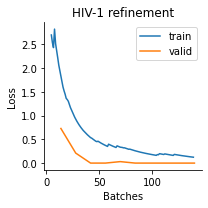

In [25]:
fig, ax = plt.subplots(1,1, figsize = (3,3))

refine_learner.recorder.plot_loss()
sbn.despine()
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("HIV-1 refinement")

plt.tight_layout()
plt.savefig("HIV_RPI_training_curve.png", dpi = 300)

In [26]:
def calculate_avg_train_val_diff_across_final_epochs(learner, epochs) -> float:
    return np.diff(np.array(learner.recorder.values[-epochs:]), axis = 1).mean().round(4)

calculate_avg_train_val_diff_across_final_epochs(refine_learner, 100)

-0.4153

In [27]:
_, val_loss  = zip(*refine_learner.recorder.values)

max_val_loss = max(val_loss)
min_val_loss = min(val_loss)

print(f"""
Max validation loss: {round(max_val_loss,4)}
Min validation loss: {round(min_val_loss,4)}
""")


Max validation loss: 0.7276
Min validation loss: 0.0



In [32]:
learner.model.blocks.rna

ModuleList(
  (0): StackedResBlock(
    (input_layer): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv1d(1024, 70, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): Sigmoid()
          (2): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ConvLayer(
          (0): Conv1d(70, 70, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idpath): Sequential(
        (0): ConvLayer(
          (0): Conv1d(1024, 70, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (act): Sigmoid()
    )
    (hidden_layers): ModuleList(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(70, 40, kernel_size=(3,), stride=

In [28]:
shape_reformatter = BlockInputShapeReformatter()
BLOCKNAME = "StackedRes"

refined_data = [shape_reformatter.reformat_input(BLOCKNAME, data[i].float()) for i in range(2)] + [data[-1].float()]
proteins, rnas, y_true = refined_data
y_true = y_true.reshape(-1,1)

In [29]:
refine_learner.model.eval()
y_pred = refine_learner.model(rnas.cuda(), proteins.cuda()).cpu().detach().round()

print(f"ACCURACY: {round(accuracy_score(y_true, y_pred),3)}")
print(f"BALANCED ACCURACY: {round(balanced_accuracy_score(y_true, y_pred),3)}")
print(f"F1 SCORE: {round(f1_score(y_true, y_pred),3)}")
print(f"ROC AUC: {round(roc_auc_score(y_true, y_pred),3)}")
print(f"MCC: {round(matthews_corrcoef(y_true, y_pred),3)}")

ACCURACY: 1.0
BALANCED ACCURACY: 1.0
F1 SCORE: 1.0
ROC AUC: 1.0
MCC: 1.0


In [31]:
# even though loaded models != learner.model, it results in identical predictions
refine_learner.model.eval();
torch.save(refine_learner.model, "../Models/TatRefinedMainModel.torch")